<a id='Top'></a>
#  The 2-Body Problem and Binary Stars

*Colin Leach, October 2018*

## Contents

- [The Gravitational 2-Body Problem](#2body)
- [Interactive plot of the 2-body problem](#2bodyint)
- [Binary Stars](#binary)
- [Binary simulation](#sim)
- [Run simulation](#runsim)
- [Plot simulation](#plotsim)
- [Eclipse?](#eclipse)
- [References](#refs)

<a id='2body'></a>
## The Gravitational 2-Body Problem

The 1-body problem assumes a *fixed* central mass with a much lighter body in a Keplerian orbit around it. What if both bodies are free to move? In particular, what if they are of comparable mass, so that the joint center of mass (CoM) is in free space between the bodies?

Fortunately, by working in the CoM frame (i.e. the CoM is stationary at the origin) we can state some fairly simple principles about the resulting mutual orbit:

- The bodies are in elliptical orbits sharing a common focus at the CoM
- At any time, the line joining the two bodies must pass through this common focus
- The 2-body problem is *mathematically* (not physically) equivalent to a 1-body problem with a *reduced mass* $\mu$ in a Keplerian orbit around a stationary *total mass* $M$ at the CoM.



For bodies with masses $m_1$ and $m_2$, the total mass is: $$M = m_1 + m_2$$

The reduced mass is: $$\mu = \frac{m_1 m_2}{M}$$

From Kepler's Third Law, the semi-major axis of the binary system is 
$$a = \sqrt[3]{\frac{P^2 G M}{4 \pi^2}}$$

The individual stars have semi-major axes about the center of mass: 
$$a_1 = \frac{\mu}{m_1} a \qquad a_2 = \frac{\mu}{m_2} a \quad \Rightarrow \quad a_1 + a_2 = a$$

The 1-body problem has the usual solution: $$r = \frac{a(1-e^2)}{1 + e \cos \phi}$$
The individual position vectors are (note opposite signs):
$$\mathbf{r}_1 = -\frac{\mu}{m_1} \mathbf{r} \qquad \mathbf{r}_2 = \frac{\mu}{m_2} \mathbf{r}$$

The individual orbits are thus scaled-down versions of the 1-body orbit, with the same eccentricity $e$ and phase angle $\phi$.

<a id='2bodyint'></a>
## Interactive plot of the 2-body problem

I find this hard to visualize just from reading about it, so let's set up some interactive graphics. First the usual definitions:

In [21]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, HTML, display, clear_output
from matplotlib.offsetbox import AnchoredText

from ipywidgets import interact, interactive, fixed, interact_manual, Layout, Output
import ipywidgets as w

from astropy import units as u
from astropy.constants import G, sigma_sb, L_sun

Next define a plotting function:

In [43]:
def plot2body(mratio, e, phi=0):
    """
    Here we use arbitrary units, assuming P = 1, a = 1
    m_2 = 1, m_1 = mratio >= 1
    phi in degrees
    """
    
    m_2 = 1
    m_1 = mratio
    M = 1 + mratio
    mu = mratio/M
    a_1 = mu/m_1
    a_2 = mu/m_2
    
    # get some evenly-spaced phase angles
    phis = np.linspace(0, 2*np.pi, 100)
    # 1-body orbit, polar coords
    rs = (1-e**2)/(1 + e*np.cos(phis))
    # individual orbits
    r1s = -mu/m_1*rs
    r2s = mu/m_2*rs
    
    # now convert to cartesian coords
    xs = rs*np.cos(phis)
    ys = rs*np.sin(phis)
    x1s = r1s*np.cos(phis)
    y1s = r1s*np.sin(phis)
    x2s = r2s*np.cos(phis)
    y2s = r2s*np.sin(phis)
    
    # current positions
    phi_rad = phi*np.pi/180 # deg to rad conversion
    r = (1-e**2)/(1 + e*np.cos(phi_rad))
    r1 = -mu/m_1*r
    r2 = mu/m_2*r
    r_curr = np.array([r, r1, r2])
    x_curr = r_curr*np.cos(phi_rad)
    y_curr = r_curr*np.sin(phi_rad)
    
    # the plot
    figwidth = 10
    fig2body = plt.figure(figsize=(figwidth, figwidth))
    plt.plot(xs, ys, 'b-', label='1-body')
    plt.plot(x1s, y1s, 'r-', label='$m_1$')
    plt.plot(x2s, y2s, 'g-', label='$m_2$')
    plt.axis('equal')
    plt.plot(0,0,'y+',markersize=20)
    plt.plot(x_curr, y_curr, 'ko')
    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.legend(fontsize=16)
    plt.title('Orbits with e = {:.2f}, mass ratio {:.1f}, phi {}'
              .format(e, mratio, phi), fontsize=20)
    plt.show()

Set up the slider controls for interaction with the plot. Continuous update probably needs to be turned off, so the plot will redraw once you release the slider (mouse button up).

In [44]:
style = {'description_width': 'initial'} # to avoid the labels getting truncated
interact(plot2body, 
            mratio = w.FloatSlider(description="mass ratio (>1)", style=style,
                                        layout=Layout(width='80%'),
                                        continuous_update=False, # otherwise flicker is horrible
                                        min=1.0, max=10, 
                                        value=3.0), 
            e = w.FloatSlider(description="Eccentricity", style=style,
                                        layout=Layout(width='80%'),
                                        continuous_update=False, 
                                        min=0.0, max=0.99, step=0.01,
                                        value=0.3),            
            phi = w.IntSlider(description="current angle (deg)", style=style,
                                        layout=Layout(width='80%'),
                                        continuous_update=False,
                                        min=0, max=359, 
                                        value=30));


interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='mass ratio (>1)', layout=La…

Notice the limiting cases:
- if $m_1 \gg m_2$, $m_2$ approaches $\mu$ and $m_1$ hardly moves: we have a 1-body approximation
- if $e = 0$, all orbits are concentric circles

<a id='binary'></a>
## Binary Stars

After considering the 2-body problem in the abstract, now let's focus on a common astronomical example. The aim is a simple binary star simulation, giving position, velocity and light curve information.

This part of the code borrows from the method of Carroll and Ostlie, Appendix K. I have simplified it somewhat, particularly by omitting proper motions of the CoM, but added more interactivity and visuals.

Obviously, this is far from being research-grade software. Simplifying assumptions include:
- the two stars are spherically symmetrical, no tidal distortions or centrifugal effects
- they do not collide
- surface fluxes are uniform and depend only on stellar radius

Features used by the simulation include:
- elliptical orbits
- arbitrary inclination
- arbitrary periastron angle
- a simple model of limb darkening

In addition to the 2-body motions, we will also want to simulate light curves. We know the temperatures $T_e$ for each star, so the luminosities come from the Stefan-Boltzmann equation:
$$ L = 4 \pi R^2 \sigma T_e^4 $$

All the input parameters and results will be stored in a single dictionary called `stars`. Putting this in the top scope is maybe a bit questionable, but it saves a lot of parameter passing.

In [24]:
stars = {}

It is useful to create some reasonable initial values for the simulation to work with. These can be changed later, and we will set up interactive controls for this.

Starting parameters include two angles, both in degrees. Inclination `i` ranges from $0^{\circ}$ for a face-on view to $90^{\circ}$ for an edge-on view. Edge-on is good, it gives us eclipses and a lot more useful information.

Periastron is the point of closest approach to the center of mass. Orientation of periastron $\phi$ is the angle between periastron for star 1 and the positive $x$ axis.

In [25]:
def setDefaults():
    # star #1
    m1_Msun = 1
    R1_Rsun = 1
    T1 = 5777  # that's our sun

    # star #2
    m2_Msun = 2.9
    R2_Rsun = 2.2
    T2 = 9800 # an A0 star

    # orbit
    P_day = 1500 # period (days)
    e = 0.5      # eccentricity
    i = 90       # inclination to the line of sight (deg)
    phi = 60     # orientation of periastron (deg)

    setInput(m1_Msun, R1_Rsun, T1, m2_Msun, R2_Rsun, T2, P_day, e, i, phi)

In [26]:
def setStars():

    M = (stars['m1'] + stars['m2'])
    a = ((stars['P']**2 * G * M)/(4*np.pi**2))**(1/3)
    mu = (stars['m1'] * stars['m2'])/M
    a1 = (mu/stars['m1'])*a
    a2 = (mu/stars['m2'])*a

    if a < stars['R1'] + stars['R2']:
        print("Error: your two stars are in contact!")
        print()
        stars['Error'] = "Your two stars are in contact"
        return False
    else:
        stars['M'] = M
        stars['mu'] = mu
        stars['a'] = a
        stars['a1'] = a1
        stars['a2'] = a2
        
        # Calculate luminosities from the Stefan-Boltzmann equation
        stars['L1'] = 4*np.pi * stars['R1']**2 * sigma_sb * stars['T1']**4
        stars['L2'] = 4*np.pi * stars['R2']**2 * sigma_sb * stars['T2']**4
        stars['L'] = stars['L1'] + stars['L2']


Two coordinates systems are relevant. The stars orbit in the $(x,y)$ plane. This is tilted at an inclination angle $i$ to the $(y',z')$ plane, the plane of the sky. The observer is on the positive $x'$ axis.
<img src="../files/twostars_axes.svg" style="width: 400px;" />

The coordinate transformations are:
$$ \begin{align}
   x' &= z \cos i + x \sin i \\
   y' &= y \\
   z' &= z \sin i - x \cos i 
   \end{align}$$

Some functions used in calculating flux are defined in a separate file:

In [27]:
from StellarBinary_suppl import transformation
from StellarBinary_suppl import limbDarkening, F, fluxIntegral, eclipse

Next, define how to identify eclipses and calculate dips in the light curve.

This is probably the most confusing part of the code (as I discovered during debugging). It is also where we get the benefit of assuming both stars are perfectly spherical, as this makes the geometry of the problem much more symmetrical than in the real-world case and saves significant computation.
<img src="../files/eclipse1.svg" style="width: 700px;" />
The left diagram shows the basic geometry, with the larger, redder star in front of and overlapping the smaller yellow star. There is a line of symmetry passing through both centers (background $bc$ and foreground $fc$). This line makes an angle $\theta'_0$ with the $y'$ axis.

The algorithm goes something like this:
- For the current position in the Keplerian orbit $(x,y)$, get the corresponding plane-of-sky coordinates $(x',y',z')$
- Decide which star is in front of which. The centers are $fc$ and $bc$ respecively.
- If the distance between star centers in these coordinates is less than the sum of radii, we have an eclipse
- Find the line of symmetry passing through both star centers. This is at angle
$$ \theta'_0 = \tan^{-1} \left( \frac{z'_{fc} - z'_{bc}}{y'_{fc} - y'_{bc}} \right) $$
- Find the maximum radius $r$ on the background star where there is overlap. As drawn, this is simply $R_b$, but for a small foreground star its disk could be entirely within the background disk.
- Integrate over arcs of radius $r'$ and thickness $dr'$, working inwards towards $bc$. 
- Within each arc, integrate over asub-arc of width $d\theta'$ at angle $\theta'$, working anticlockwise from the symmetry line at $\theta'_0$. Stop when there is no more overlap or $\theta'$ has covered a full semicircle.
- For each area $dA = r' dr' d\theta'$ calculate the flux drop $dS = 2 \times F(dA)$, relative to non-overlapping disks. The factor of 2 covers the other side of the symmetry line, which we avoided calculating explicitly.
- Return $dS$ for theses star positions, along with the primed coordinates for both star centers.


<a id='sim'></a>
## The simulation!

Define the actual simulation run. The mathematical bit is fairly concise code but there are a lot of lines just handling storage of the results.

Calculating motions in the orbital plane is similar to the KeplerOrbit notebook, except that here we make no assumptions about the relative masses of the two objects. Instead we calculate the orbit of a reduced mass $\mu$ in the center of mass reference frame, then translate from this to the positions of each star. 

The angular momentum is
$$ L_{ang} = \mu \sqrt{G M a (1-e^2)} $$
and 
$$ \frac{dA}{dt} = \frac{1}{2} r^2 \frac{d \theta}{dt} = \frac{1}{2} \frac{L}{\mu} \quad \Rightarrow \quad d \theta = \frac{dA}{dt} \frac{1}{r^2} dt $$


In [28]:
from StellarBinary_suppl import runSim, saveData

Writing data to disk is not often useful, but saveData() is a function that can be called if necessary.

For no adequate scientic reason (just playing), let's estimate what color the stars would appear to us:

In [29]:
from StellarBinary_suppl import lookup_temp

Define a graphing function that will be called later. This will output a $2 \times 3$ grid of different plots, so there is a lot of rather boring housekeeping code.

In [30]:
from StellarBinary_suppl import plotOrbit

For each star we want mass `m` (units of $M_{\odot}$), radius `R` ($R_{\odot}$), temperature `T` ($K$).

For the orbit we want period `P` (days), eccentricity `e`, orbital inclination `i` (deg) and orientation of periastron `phi` (deg). The inclination needs to be fairly near $90^{\circ}$ if you want eclipses.

In [31]:
def setInput(m1_Msun, R1_Rsun, T1, m2_Msun, R2_Rsun, T2, P_day, e, i, phi):

    # star #1
    m1_Msun = m1_Msun * u.M_sun
    R1_Rsun = R1_Rsun * u.R_sun
    T1 = T1 * u.K # that's our sun

    # star #2
    m2_Msun = m2_Msun * u.M_sun
    R2_Rsun = R2_Rsun * u.R_sun
    T2 = T2 * u.K # an A0 star

    # orbit
    P_day = P_day * u.day
    i = i * u.deg
    phi = phi * u.deg

    # empty the data dictionary for a fresh start
    stars.clear()
    
    # create variables in SI units for calculations and put everything in a single dictionary
    stars['m1'] = m1_Msun.to(u.kg)
    stars['R1'] = R1_Rsun.to(u.m)
    stars['T1'] = T1
    stars['m2'] = m2_Msun.to(u.kg)
    stars['R2'] = R2_Rsun.to(u.m)
    stars['T2'] = T2
    stars['P'] = P_day.to(u.s)
    stars['e'] = e
    stars['i'] = i
    stars['phi'] = phi
    
    setStars()

<a id='runsim'></a>
## Go...

With all the functions defined, now we can start running things.

In [32]:
setDefaults()

There are a lot of inputs to this simulation and setting them interactively could get complicated. 

Let's start by creating some useful widgets and storing them for later.

In [33]:
from StellarBinary_suppl import widgetDict

wd = widgetDict(stars)

The `update()` function will be called whenever the interactive controls change. It updates the `stars` dictionary with latest starting values, but does not re-run the simulation or plot (by default).

In [34]:
def update(m1_Msun, R1_Rsun, T1, m2_Msun, R2_Rsun, T2, P_day, e, i, phi):
    setInput(m1_Msun, R1_Rsun, T1, m2_Msun, R2_Rsun, T2, P_day, e, i, phi)
    
    display("a1: {:.2f}, L1: {:2g}, a2: {:.2f}, L2: {:2g}, mu: {:f}".
        format(stars['a1'].to(u.AU), stars['L1'], stars['a2'].to(u.AU), stars['L2'], stars['mu'].to(u.M_sun)))
#     return "a1: {:.2f}, L1: {:2g}, a2: {:.2f}, L2: {:2g}, mu: {:f}".format(
#         stars['a1'].to(u.AU), stars['L1'], stars['a2'].to(u.AU), stars['L2'], stars['mu'].to(u.M_sun))
    
#     removing the previous line of display would be good, but clear_output() also removed the control widgets
#         clear_output(wait=True)
#     I don't have a better approach right now
    
#     plotOrbit can take a few seconds per update
#     uncomment this line if you are patient or have a very fast machine
#     plotOrbit()

#     Otherwise, run plotOrbit() manually from the last cell in this notebook

As of mid-2018, Matplotlib `ipywidgets.interact()` does not support layouts other than a single vertical set of controls. This has been discussed by the developers, e.g. [issue 1731](https://github.com/jupyter-widgets/ipywidgets/issues/1731), and may be fixed in a future release. Meanwhile this `interact_hookup()` hack is adapted from [issue 910](https://github.com/jupyter-widgets/ipywidgets/issues/910).

Displaying an update of calculated values (distances and luminosities) is still ugly. Any suggestions for fixes?

This is the default `interact()` setup. Maybe something to go back to if the more complex hack breaks?

In [35]:
# # style = {'description_width': 'initial'} # to avoid the labels getting truncated
# interact(update, m1_Msun = wd['m1_Msun'], R1_Rsun = wd['R1_Rsun'], T1 = wd['T1'], 
#                 m2_Msun = wd['m2_Msun'], R2_Rsun = wd['R2_Rsun'], T2 = wd['T2'],
#                 P_day = wd['P_day'], e = wd['e'], i = wd['i'], phi = wd['phi'],
#                 vcmxp = wd['vcmxp'], vcmyp = wd['vcmyp'], vcmzp = wd['vcmzp'],
#                 );

The control layout hack...

In [36]:
def interact_hookup(f, controls):
    def observer(change):
        kwargs = {k:v.value for k,v in controls.items()}
        f(**kwargs)
    for k,w in controls.items():
        w.observe(observer, 'value')

In [37]:
UI = w.VBox([
        w.VBox([
                w.HBox([wd['m1_Msun'], wd['R1_Rsun'], wd['T1'],], padding='100pt', margin='100pt', width='100%'),
                w.HBox([wd['m2_Msun'], wd['R2_Rsun'], wd['T2'],], width='100%'),
                w.HBox([wd['P_day'], wd['e'],], width='100%'),
                wd['i'], 
                wd['phi'],
            ]),
    ])

interact_hookup(update, wd)
display(UI)

'a1: 0.22 AU, L1: 3.84127e+26 W, a2: 0.08 AU, L2: 1.53962e+28 W, mu: 0.743590 solMass'

'a1: 0.22 AU, L1: 3.84127e+26 W, a2: 0.08 AU, L2: 1.53962e+28 W, mu: 0.743590 solMass'

'a1: 0.24 AU, L1: 3.84127e+26 W, a2: 0.04 AU, L2: 1.53962e+28 W, mu: 0.426471 solMass'

'a1: 0.14 AU, L1: 3.84127e+26 W, a2: 0.07 AU, L2: 1.53962e+28 W, mu: 0.333333 solMass'

'a1: 0.14 AU, L1: 3.84127e+26 W, a2: 0.07 AU, L2: 1.53962e+28 W, mu: 0.333333 solMass'

'a1: 0.14 AU, L1: 3.84127e+26 W, a2: 0.07 AU, L2: 1.53962e+28 W, mu: 0.333333 solMass'

'a1: 0.14 AU, L1: 3.84127e+26 W, a2: 0.07 AU, L2: 1.53962e+28 W, mu: 0.333333 solMass'

'a1: 0.30 AU, L1: 3.84127e+26 W, a2: -0.15 AU, L2: 1.53962e+28 W, mu: -1.000000 solMass'

/home/colin/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


'a1: nan AU, L1: 3.84127e+26 W, a2: nan AU, L2: 1.53962e+28 W, mu: 3.000000 solMass'

'a1: 0.17 AU, L1: 3.84127e+26 W, a2: 0.03 AU, L2: 1.53962e+28 W, mu: 0.166667 solMass'

'a1: 0.17 AU, L1: 8.64285e+26 W, a2: 0.03 AU, L2: 1.53962e+28 W, mu: 0.166667 solMass'

'a1: 0.17 AU, L1: 3.84127e+26 W, a2: 0.03 AU, L2: 1.53962e+28 W, mu: 0.166667 solMass'

'a1: 0.20 AU, L1: 3.84127e+26 W, a2: 0.03 AU, L2: 1.53962e+28 W, mu: 0.176471 solMass'

<a id='plotsim'></a>
## Now run the simulation and plot it

Doing this automatically from the interactive controls is a bit tedious, even on a reasonably fast machine. Just run the cell below and it will use current values for the various parameters.

Note that the "plane of sky" plot can look odd. It includes proper motions, so the stars may not return to their starting positions. Also, keep an eye on the axis scaling: the $x$ and $y$ axes may or may not be equal, to avoid everything disappearing into a horizontal line for an edge-on orbit.

Both orbit plots show the (almost) first position of the stars, $t=0$, with some indication of their relative sizes and colors. 

The blue cross is the center of mass at $t=0$. If it's not visible, it's probably covered by the larger star.

_UI glitch:_ sometimes the orbit plots will collapse into a scrollable box, which is confusing. Clicking on the blank area to the left of the plots (below "In []") should fix this.

sim took 5.247 s


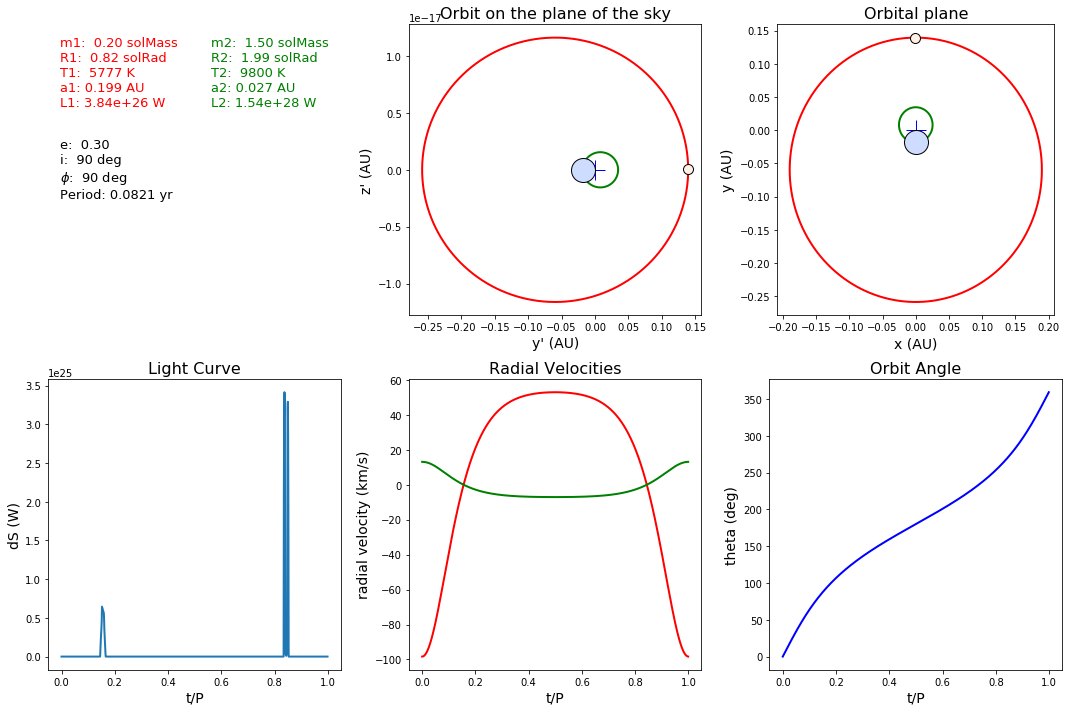

In [49]:
plotOrbit(stars)

<a id='eclipse'></a>
## Find the eclipse (if any)

You can see from the above light curve if there are dips, but the code needs to do this more precisely.

The `argrelextrema()` function seems to be a convenient way to find local maxima. For real data you would want to apply smoothing first, but our simulated data is already artificially clean.

Note that this function always returns a tuple with $N$ entries, for an $N$-dimensional data set. We have a 1-D array so take the first (and only) element from the tuple.

In [39]:
from scipy.signal import argrelextrema

def star_in_front(n):
    " compare coords along line of sight and return # of front star"
    if stars['xp_diff'][b] > 0:
        return 1
    else:
        return 2    

blips = argrelextrema(stars['dS'], np.greater)[0]

blipcount = len(blips)
print("There are {} eclipses during the orbit\n".format(blipcount))
if blipcount > 0:
    print("{0:>5} {1:>15} {2:>9} {3:>18}".format("t/P","elapsed time","dS","Star in front"))
    for b in blips:
        print("{0:#6.3g} {1:#10.4g} {2:#11.2g} {3:10n}".
              format(stars['t_P'][b], (stars['t_P'][b]*stars['P']).to(u.year), stars['dS'][b], star_in_front(b)))
else:
    print("If you want to play with eclipse data, try running a simulation with i close to 90 deg")

There are 2 eclipses during the orbit

  t/P    elapsed time        dS      Star in front
 0.170     0.6982 yr     6.0e+24 W          2
 0.945      3.881 yr     5.5e+23 W          1


What would each eclipse look like from our line of sight, if we had an impossibly perfect telescope? We have enough data to draw this (very crudely) with SVG.

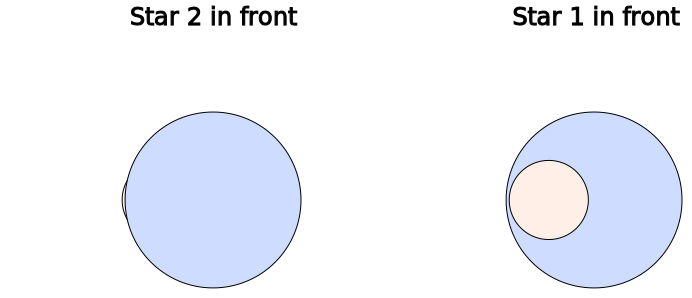

In [40]:
from svgscene import SVGScene # expect a .py file in same directory

if blipcount > 0:
    scene = SVGScene()
    
    # TODO - making everything automatically fit nicely needs more effort!
    #        meanwhile, each sim may need these values tweaked
    x = 200
    y = 200
    scale_factor = 40
    
    for b in blips:
        front = star_in_front(b)
        if front == 1:
            R_f = stars['R1'].to(u.R_sun).value * scale_factor
            color_f = lookup_temp(stars['T1'].value)
            yp_f = stars['y1p'][b].to(u.R_sun).value * scale_factor
            zp_f = stars['z1p'][b].to(u.R_sun).value * scale_factor
            R_b = stars['R2'].to(u.R_sun).value * scale_factor
            color_b = lookup_temp(stars['T2'].value)
            yp_b = stars['y2p'][b].to(u.R_sun).value * scale_factor
            zp_b = stars['z2p'][b].to(u.R_sun).value * scale_factor
        else:
            R_f = stars['R2'].to(u.R_sun).value * scale_factor
            color_f = lookup_temp(stars['T2'].value)
            yp_f = stars['y2p'][b].to(u.R_sun).value * scale_factor
            zp_f = stars['z2p'][b].to(u.R_sun).value * scale_factor
            R_b = stars['R1'].to(u.R_sun).value * scale_factor
            color_b = lookup_temp(stars['T1'].value)
            yp_b = stars['y1p'][b].to(u.R_sun).value * scale_factor
            zp_b = stars['z1p'][b].to(u.R_sun).value * scale_factor
            
        scene.text((x-70, 25), "Star {} in front".format(front))
        scene.circle((x+yp_b, y), R_b, color_b)
        scene.circle((x+yp_f, y+zp_f-zp_b), R_f, color_f)
        
        # move right for showing the next eclipse
        x = x + 3*(R_f + R_b)  
            
    display(scene)

<a id='refs'></a>
# References

```"An Introduction to Modern Astrophysics", Appendix K
Bradley W. Carroll and Dale A. Ostlie
Second Edition, Addison Wesley, Copyright 2007.```